In [236]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import os 
import glob


# Create a custom color map from white to black
white_black_cmap = LinearSegmentedColormap.from_list('white_black', ['white', 'black'], N=256)


In [237]:
def merge_seeds(file_name_pattern='CUB_results_s*_hessian_exact.csv', data_dir='./logs/ISR_Hessian_results_new'):
    # Create the full pattern for glob
    full_pattern = os.path.join(data_dir, file_name_pattern)

    # Use glob to get all file paths matching the pattern
    all_files = glob.glob(full_pattern)

    # Initialize an empty list to hold the dataframes
    df_list = []

    # Loop through the files, read each into a dataframe, and append it to the list
    for file_path in all_files:
        df = pd.read_csv(file_path)
        df_list.append(df)

    # Concatenate all the dataframes in the list
    merged_df = pd.concat(df_list, ignore_index=True)
    if 'penalty_anneal_iters' not in merged_df.columns:
        merged_df['penalty_anneal_iters'] = 0
    if 'fishr' in file_name_pattern:
        merged_df = merged_df[['dataset','seed','split','method','ISR_class','ISR_scale','num_iter', 'ema','lambda','penalty_anneal_iters', 'acc-0', 'acc-1', 'acc-2', 'acc-3', 'worst_group', 'avg_acc', 'worst_acc']]
    else:
        merged_df = merged_df[['dataset','seed','split','method','ISR_class','ISR_scale','num_iter', 'gradient_alpha', 'hessian_beta','penalty_anneal_iters', 'acc-0', 'acc-1', 'acc-2', 'acc-3', 'worst_group', 'avg_acc', 'worst_acc']]
    if 'CUB' in file_name_pattern:
        merged_df = merged_df[merged_df['num_iter']==300]
    elif 'CelebA' in file_name_pattern:
        merged_df = merged_df[merged_df['num_iter']==50]
    elif 'MultiNLI' in file_name_pattern:
        merged_df = merged_df[merged_df['num_iter']==3]
    if 'fishr' in file_name_pattern:
        grouped = merged_df.groupby(['dataset', 'split', 'method', 'ISR_class', 'ISR_scale',
                                     'num_iter','ema','lambda','penalty_anneal_iters']).agg({
            'avg_acc': ['mean', 'sem'],
            'worst_acc': ['mean', 'sem']
        })
    else:
        merged_df.fillna(0, inplace=True)
        grouped = merged_df.groupby(['dataset', 'split', 'method', 'ISR_class', 'ISR_scale',
                                'num_iter', 'gradient_alpha', 'hessian_beta','penalty_anneal_iters']).agg({
            'avg_acc': ['mean', 'sem'],
            'worst_acc': ['mean', 'sem']
        })
    # Renaming the columns for clarity
    grouped.columns = ['avg_acc_mean', 'avg_acc_sem', 'worst_acc_mean', 'worst_acc_sem']
    # Resetting the index if you want the grouped columns back as regular columns
    grouped = grouped.reset_index()
    # cleaned_grouped = grouped.dropna(subset=['avg_acc_sem', 'worst_acc_sem'])
    cleaned_grouped = grouped
    # Display the cleaned DataFrame
    # print(cleaned_grouped)
    val = cleaned_grouped[cleaned_grouped['split'] == 'val']
    test = cleaned_grouped[cleaned_grouped['split'] == 'test']
    num_runs = len(all_files)
    dataset = file_name_pattern.split('_')[0]
    if 'fishr' in file_name_pattern:
        val.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_fishr_val.csv', index=False)
        test.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_fishr_test.csv', index=False)
    else:
        val.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_val.csv', index=False)
        test.to_csv(f'{data_dir}/{dataset}_{num_runs}runs_test.csv', index=False)
    # print(f"Saved {dataset}_{num_runs}runs_val.csv and {dataset}_{num_runs}runs_test.csv in {data_dir}")
    return val, test

In [249]:
merge_seeds(file_name_pattern='CUB_results_s*_hessian_exact.csv', data_dir='./logs/ISR_Hessian_results_new')
merge_seeds(file_name_pattern='CelebA_results_s*_hessian_exact.csv', data_dir='./logs/ISR_Hessian_results_new')
merge_seeds(file_name_pattern='MultiNLI_results_s*_hessian_exact.csv', data_dir='./logs/ISR_Hessian_results_new')


# Example DataFrame
cub_file = 'CUB_5runs_val.csv'
celeba_file = 'CelebA_5runs_val.csv'
multinli_file = 'MultiNLI_5runs_test.csv'

cub_file_fishr = 'CUB_5runs_fishr_val.csv'
celeba_file_fishr = 'CelebA_5runs_fishr_val.csv'
multinli_file_fishr = 'MultiNLI_5runs_fishr_val.csv'

# df = pd.read_csv(os.path.join('./logs/ISR_Hessian_results_new', cub_file))
# df = pd.read_csv(os.path.join('./logs/ISR_Hessian_results_new', celeba_file))
df = pd.read_csv(os.path.join('./logs/ISR_Hessian_results_new', multinli_file))

if df['dataset'].iloc[0] == 'CUB':
    acc_min, acc_max = 0.8, 0.9
elif df['dataset'].iloc[0] == 'CelebA':
    acc_min, acc_max = 0.5, 0.70
elif df['dataset'].iloc[0] == 'MultiNLI':
    acc_min, acc_max = 0.5, 0.7
# Creating a pivot table, averaging over 'penalty_anneal_iters'
pivot_df = df.pivot_table(values='worst_acc_mean', index='gradient_alpha', columns='hessian_beta', aggfunc='mean')


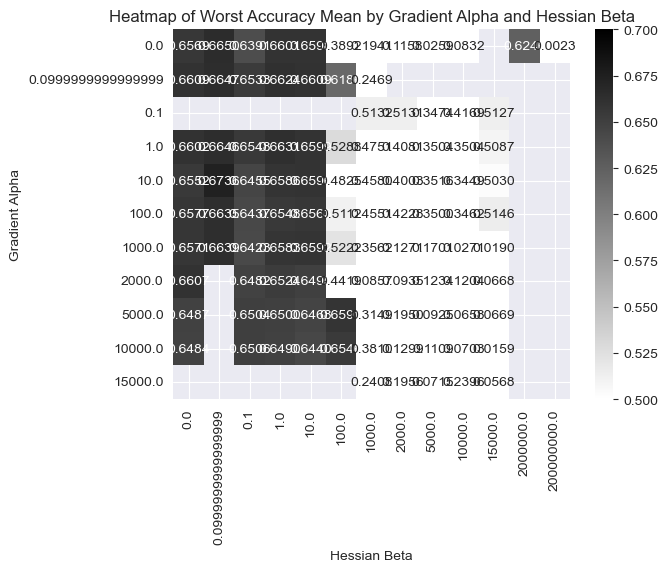

In [250]:
sns.heatmap(pivot_df, annot=True, cmap=white_black_cmap, fmt=".4f", vmin=acc_min, vmax=acc_max)
plt.title('Heatmap of Worst Accuracy Mean by Gradient Alpha and Hessian Beta')
plt.xlabel('Hessian Beta')
plt.ylabel('Gradient Alpha')
plt.show()

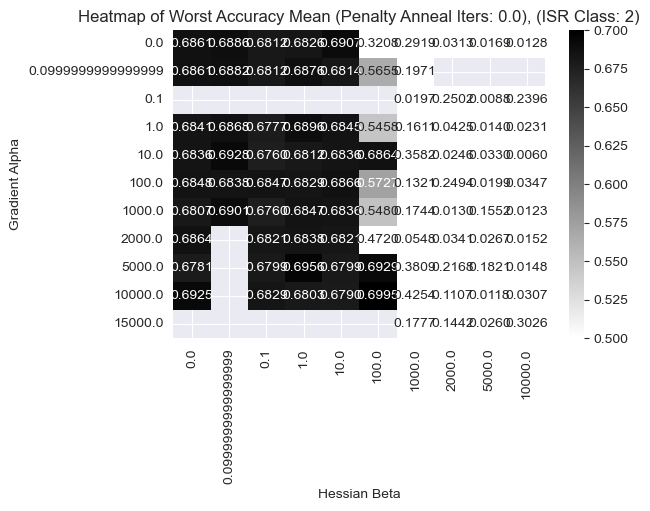

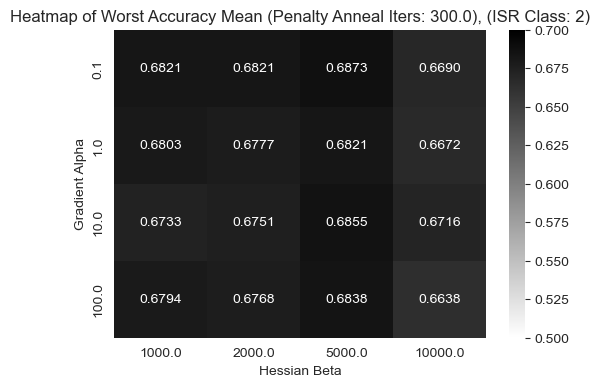

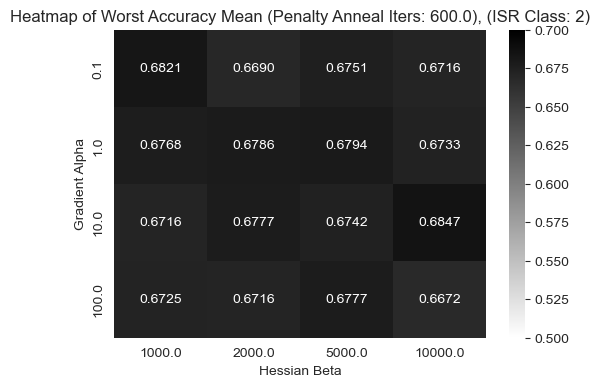

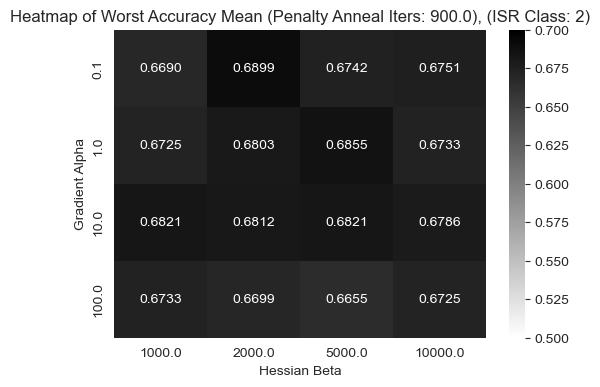

In [251]:
# We can create multiple heatmaps for each unique pairs value of 'ISR_class'and 'penalty_anneal_iters'
from itertools import product
df = df[df['hessian_beta'] <= 10000]
unique_iters = product(df['penalty_anneal_iters'].unique(), df['ISR_class'].unique())
# unique_iters = df['penalty_anneal_iters'].unique()

# for iters, isr_class in unique_iters:
for iters, isr_class in product(df['penalty_anneal_iters'].unique(), [2]):
    sub_df = df[df['penalty_anneal_iters'] == iters]
    sub_df = sub_df[sub_df['ISR_class'] == isr_class]
    pivot_df = sub_df.pivot_table(values='worst_acc_mean', index='gradient_alpha', columns='hessian_beta', aggfunc='mean')
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot_df, annot=True, cmap=white_black_cmap, fmt=".4f", vmin=acc_min, vmax=acc_max)
    plt.title(f'Heatmap of Worst Accuracy Mean (Penalty Anneal Iters: {iters}), (ISR Class: {isr_class})')
    plt.xlabel('Hessian Beta')
    plt.ylabel('Gradient Alpha')
    plt.show()


In [231]:
df = pd.read_csv(os.path.join('./logs/ISR_Hessian_results_new', multinli_file_fishr))
df

,dataset,split,method,ISR_class,ISR_scale,num_iter,ema,lambda,penalty_anneal_iters,avg_acc_mean,avg_acc_sem,worst_acc_mean,worst_acc_sem,num_runs,seed_runs
0,MultiNLI,val,Fishr-Mean,0,0,3,0.90,10.0,0.0,0.822063,NaN,0.648683,NaN,1,[0]
1,MultiNLI,val,Fishr-Mean,0,0,3,0.90,10.0,300.0,0.823373,NaN,0.658720,NaN,1,[0]
2,MultiNLI,val,Fishr-Mean,0,0,3,0.90,10.0,600.0,0.824355,NaN,0.668758,NaN,1,[0]
3,MultiNLI,val,Fishr-Mean,0,0,3,0.90,100.0,0.0,0.825192,NaN,0.652447,NaN,1,[0]
4,MultiNLI,val,Fishr-Mean,0,0,3,0.90,100.0,300.0,0.825423,NaN,0.671267,NaN,1,[0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,MultiNLI,val,Fishr-Mean,2,0,3,0.99,1000.0,900.0,0.824234,NaN,0.691343,NaN,1,[0]
234,MultiNLI,val,Fishr-Mean,2,0,3,0.99,10000.0,0.0,0.823458,NaN,0.677541,NaN,1,[0]
235,MultiNLI,val,Fishr-Mean,2,0,3,0.99,10000.0,300.0,0.809985,NaN,0.644372,NaN,1,[0]
236,MultiNLI,val,Fishr-Mean,2,0,3,0.99,10000.0,600.0,0.813182,0.001927,0.711034,0.012844,5,"[0, 1, 2, 3, 4]"


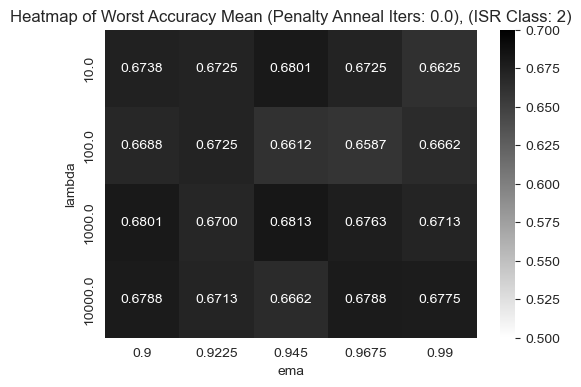

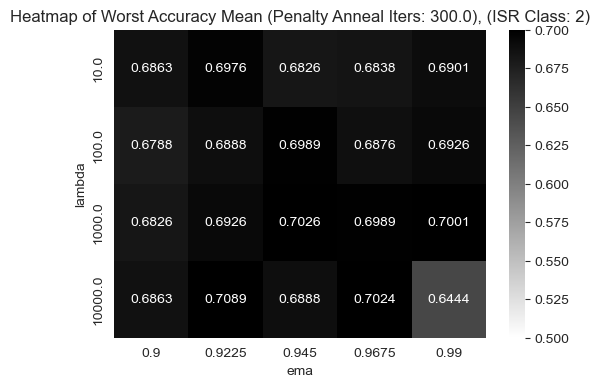

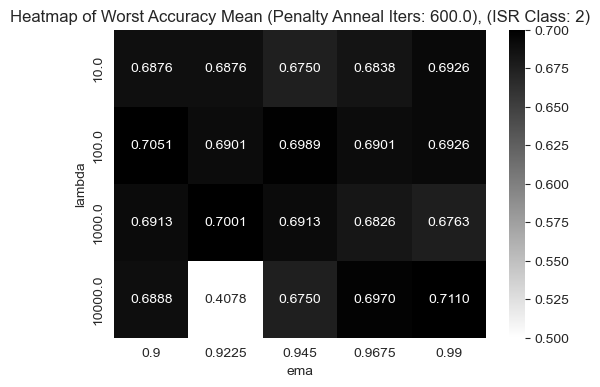

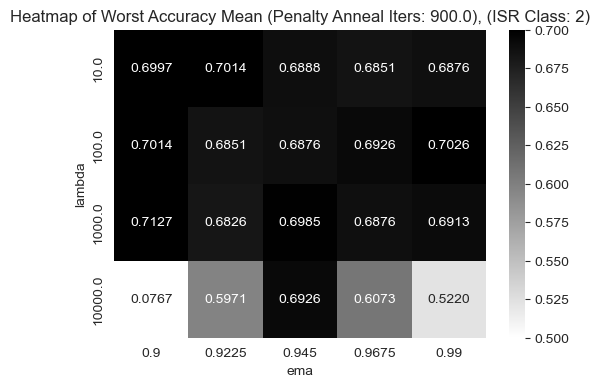

In [235]:
# We can create multiple heatmaps for each unique pairs value of 'ISR_class'and 'penalty_anneal_iters'
from itertools import product
unique_iters = product(df['penalty_anneal_iters'].unique(), df['lambda'].unique())
# unique_iters = df['penalty_anneal_iters'].unique()

# for iters, isr_class in unique_iters:
for iters, isr_class in product(df['penalty_anneal_iters'].unique(), [2]):
    sub_df = df[df['penalty_anneal_iters'] == iters]
    sub_df = sub_df[sub_df['ISR_class'] == isr_class]
    pivot_df = sub_df.pivot_table(values='worst_acc_mean', index='lambda', columns='ema', aggfunc='mean')
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot_df, annot=True, cmap=white_black_cmap, fmt=".4f", vmin=acc_min, vmax=acc_max)
    plt.title(f'Heatmap of Worst Accuracy Mean (Penalty Anneal Iters: {iters}), (ISR Class: {isr_class})')
    plt.xlabel('ema')
    plt.ylabel('lambda')
    plt.show()


In [213]:
progress_dir = './logs/ISR_training_progress'
dataset = 'CelebA'
seed = 0
ISR_class = 0
grad_alpha = 5000
hess_beta = 100
penalty_anneal_iters = 2000
grad_alpha_formatted = "{:.1e}".format(grad_alpha).replace('.0e', 'e')
hess_beta_formatted = "{:.1e}".format(hess_beta).replace('.0e', 'e')
progress_file_dir = f"ISRclass_{ISR_class}_grad_alpha_{grad_alpha_formatted}_hess_beta_{hess_beta_formatted}_anneal_{penalty_anneal_iters}.0"



df = pd.read_csv(os.path.join(progress_dir, dataset, f's{seed}', progress_file_dir, 'train.csv'))

penalty_anneal_iters = 2000
progress_file_dir = f"ISRclass_{ISR_class}_grad_alpha_{grad_alpha_formatted}_hess_beta_{hess_beta_formatted}_anneal_{penalty_anneal_iters}.0"
df8000 = pd.read_csv(os.path.join(progress_dir, dataset, f's{seed}', progress_file_dir, 'train.csv'))

In [161]:
len(df)

16300

<Axes: xlabel='epoch', ylabel='worst_acc'>

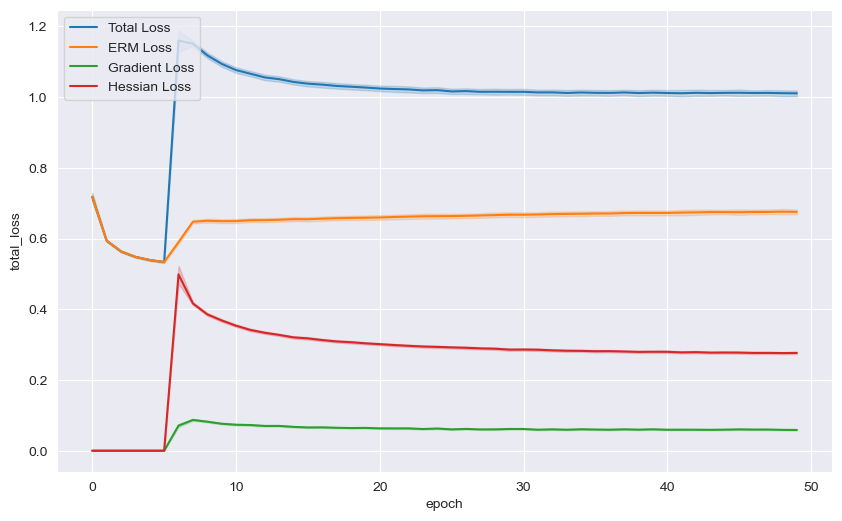

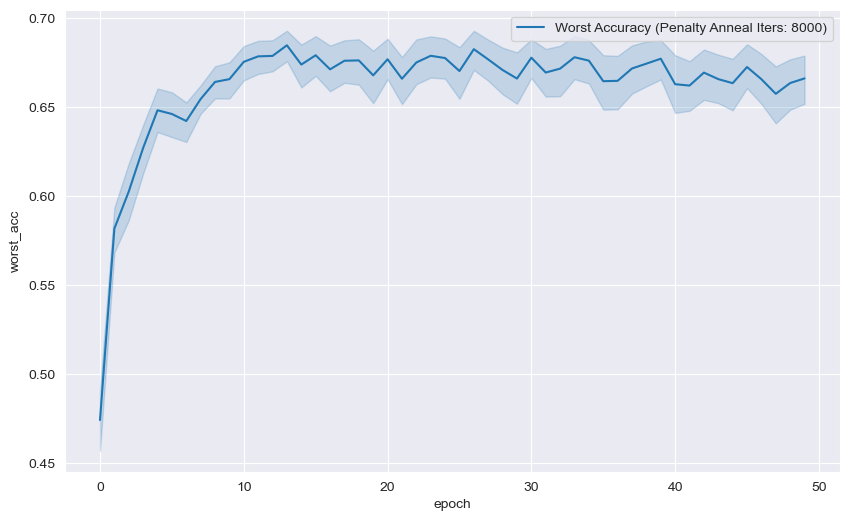

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the training progress
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='epoch', y='total_loss', label='Total Loss')
sns.lineplot(data=df, x='epoch', y='erm_loss', label='ERM Loss')
sns.lineplot(data=df, x='epoch', y='grad_loss', label='Gradient Loss')
sns.lineplot(data=df, x='epoch', y='hessian_loss', label='Hessian Loss')
# sns.lineplot(data=df, x='step', y='total_loss', label='Total Loss')
# sns.lineplot(data=df, x='step', y='erm_loss', label='ERM Loss')
# sns.lineplot(data=df, x='step', y='grad_loss', label='Gradient Loss')
# sns.lineplot(data=df, x='step', y='hessian_loss', label='Hessian Loss')


plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='epoch', y='avg_acc', label='Average Accuracy')
# sns.lineplot(data=df, x='epoch', y='worst_acc', label='Worst Accuracy')
# sns.lineplot(data=df8000, x='epoch', y='avg_acc', label='Average Accuracy (Penalty Anneal Iters: 8000)')
sns.lineplot(data=df8000, x='epoch', y='worst_acc', label='Worst Accuracy (Penalty Anneal Iters: 8000)')

# sns.lineplot(data=df, x='epoch', y='avg_acc', label='Training Accuracy')


In [191]:
new_dir = './logs/ISR_Hessian_results_new'
euler_dir = './logs/ISR_Hessian_results_euler'
combined_dir = './logs/ISR_Hessian_results_combined'
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

file_patterns = ['CelebA_results_s*_hessian_exact.csv', 'CUB_results_s*_hessian_exact.csv', 'MultiNLI_results_s*_hessian_exact.csv']

file_list = []
for file_pattern in file_patterns:
    file_list.extend(glob.glob(os.path.join(new_dir, file_pattern)))

for file_pattern in file_list:
    df_new = pd.read_csv(file_pattern)
    df_euler = pd.read_csv(file_pattern.replace(new_dir, euler_dir))
    merged_df = pd.merge(df_new, df_euler, how='inner')

    # Check if the merged DataFrame has the same number of rows as df_new
    # 
    
    if len(merged_df) == len(df_new) == len(df_euler):
        print(file_pattern)
        print("df_new and df_euler are the same")
        print("Saving df_new to file")
        df_new.to_csv(file_pattern.replace(new_dir, combined_dir), index=False)
    elif len(merged_df) == len(df_new):
        print(file_pattern)
        print("df_new is a subDataFrame of df_euler")
        print("Saving df_euler to file")
        
        df_euler.to_csv(file_pattern.replace(new_dir, combined_dir), index=False)
    elif len(merged_df) == len(df_euler):
        print(file_pattern)
        print("df_euler is a subDataFrame of df_new")
        print("Saving df_new to file")
        df_new.to_csv(file_pattern.replace(new_dir, combined_dir), index=False)
    else:
        df_concat = pd.concat([df_new, df_euler], ignore_index=True)
        print(file_pattern)
        print("df_new and df_euler are different")
        print("Saving concatenated DataFrame to file")
        df_concat.to_csv(file_pattern.replace(new_dir, combined_dir), index=False)
    
        
    # else:
        # print("df_new is not a subDataFrame of df_euler")
    # else:
    #     print("df_new is not a subDataFrame of df_euler")
    # print(file_pattern)
    # print(len(df_new), len(df_euler))

./logs/ISR_Hessian_results_new/CelebA_results_s0_hessian_exact.csv
df_new and df_euler are different
Saving concatenated DataFrame to file
./logs/ISR_Hessian_results_new/CelebA_results_s1_hessian_exact.csv
df_new and df_euler are different
Saving concatenated DataFrame to file
./logs/ISR_Hessian_results_new/CelebA_results_s4_hessian_exact.csv
df_new and df_euler are the same
Saving df_new to file
./logs/ISR_Hessian_results_new/CelebA_results_s2_hessian_exact.csv
df_new and df_euler are different
Saving concatenated DataFrame to file
./logs/ISR_Hessian_results_new/CelebA_results_s3_hessian_exact.csv
df_new and df_euler are different
Saving concatenated DataFrame to file
./logs/ISR_Hessian_results_new/CUB_results_s4_hessian_exact.csv
df_euler is a subDataFrame of df_new
Saving df_new to file
./logs/ISR_Hessian_results_new/CUB_results_s1_hessian_exact.csv
df_euler is a subDataFrame of df_new
Saving df_new to file
./logs/ISR_Hessian_results_new/CUB_results_s0_hessian_exact.csv
df_new and d

In [190]:
os.getcwd()

'/Users/yuenc2/Desktop/ISR/real_datasets'